## Forecasting with structured VAEs

For background see [(Johnson et al. 2016)](https://arxiv.org/abs/1603.06277).

In [1]:
import pyro
import torch
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.timeseries.stable import LogStableCoxProcess
from pyro.nn import PyroParam, PyroSample
from torch.distributions import constraints

%matplotlib inline
pyro.enable_validation(True)
pyro.set_rng_seed(2020012917)

## Data: 9 years of hourly rider counts among 50 train stations

In [2]:
dataset = load_bart_od()
counts = dataset["counts"]
print(dataset.keys())
print(counts.shape)
print(dataset["start_date"])
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
(datetime.datetime(2011, 1, 1, 0, 0),)
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


## Univariate forecasting

torch.Size([78888, 1])
torch.Size([469, 1])


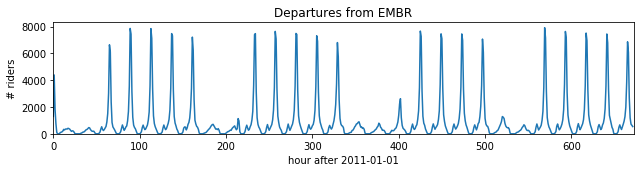

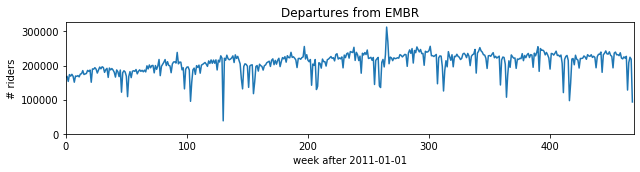

In [3]:
station = "EMBR"
station_id = dataset["stations"].index(station)

hourly_data = counts[:, station_id].sum(-1).unsqueeze(-1)
plt.figure(figsize=(9, 2.5))
plt.plot(hourly_data[:4*24*7])
plt.title("Departures from {}".format(station))
plt.xlabel("hour after {}".format(dataset["start_date"][0].strftime("%Y-%m-%d")))
plt.ylabel("# riders")
plt.xlim(0, 4*24*7)
plt.ylim(0, None)
plt.tight_layout()
print(hourly_data.shape)

weekly_data = hourly_data[:len(hourly_data) // (24 * 7) * 24 * 7]
weekly_data = weekly_data.reshape(-1, 24 * 7, 1).sum(-2)
plt.figure(figsize=(9, 2.5))
plt.plot(weekly_data[:4*24*7])
plt.title("Departures from {}".format(station))
plt.xlabel("week after {}".format(dataset["start_date"][0].strftime("%Y-%m-%d")))
plt.ylabel("# riders")
plt.xlim(0, len(weekly_data))
plt.ylim(0, None)
plt.tight_layout()
print(weekly_data.shape)

INFO 	 step    0 loss = 9.598e+04
INFO 	 step    1 loss = 9.598e+04
INFO 	 step    2 loss = 9.597e+04
INFO 	 step    3 loss = 9.597e+04
INFO 	 step    4 loss = 9.597e+04
INFO 	 step    5 loss = 9.597e+04
INFO 	 step    6 loss = 9.597e+04
INFO 	 step    7 loss = 9.597e+04
INFO 	 step    8 loss = 9.596e+04
INFO 	 step    9 loss = 9.597e+04
INFO 	 step   10 loss = 9.597e+04
INFO 	 step   11 loss = 9.597e+04
INFO 	 step   12 loss = 9.597e+04
INFO 	 step   13 loss = 9.596e+04
INFO 	 step   14 loss = 9.596e+04
INFO 	 step   15 loss = 9.596e+04
INFO 	 step   16 loss = 9.596e+04
INFO 	 step   17 loss = 9.597e+04
INFO 	 step   18 loss = 9.596e+04
INFO 	 step   19 loss = 9.596e+04
INFO 	 step   20 loss = 9.595e+04
INFO 	 step   21 loss = 9.595e+04
INFO 	 step   22 loss = 9.595e+04
INFO 	 step   23 loss = 9.596e+04
INFO 	 step   24 loss = 9.595e+04
INFO 	 step   25 loss = 9.595e+04
INFO 	 step   26 loss = 9.595e+04
INFO 	 step   27 loss = 9.595e+04
INFO 	 step   28 loss = 9.595e+04
INFO 	 step   

CPU times: user 2min 5s, sys: 53.8 s, total: 2min 59s
Wall time: 8.13 s


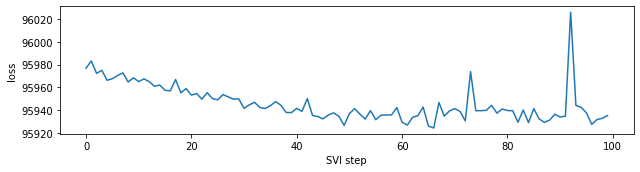

In [4]:
%%time
pyro.clear_param_store()
process = LogStableCoxProcess("rides", hidden_dim=1, obs_dim=1, max_rate=1e5)
losses = process.fit(weekly_data, learning_rate=0.1)
plt.figure(figsize=(9, 2.5))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("loss")
plt.tight_layout()

In [ ]:
trace = poutine.trace(process.posterior).get_trace(weekly_data)
for name, site in sorted(trace.nodes.items()):
    if site["type"] == "sample":
        if site["value"].numel() == 1:
            print("{} = {}".format(name, site["value"].item()))
        else:
            print("{}.shape = {}".format(name, tuple(site["value"].shape)))

In [ ]:
noise = process.detect(weekly_data)

In [ ]:
fig, axes = plt.subplots(2, figsize=(9, 4), sharex=True)
axes[0].plot(weekly_data[:4*24*7])
axes[0].set_title("Departures from {}".format(station))
axes[0].set_ylabel("# riders")
axes[0].set_ylim(0, None)
axes[0].set_xlim(0, len(weekly_data))
axes[1].plot(noise["trans"], "b-")
axes[1].plot(noise["obs"], "r-")
axes[1].set_xlabel("week after {}".format(dataset["start_date"][0].strftime("%Y-%m-%d")))
plt.tight_layout()
print(weekly_data.shape)

In [ ]:
x = torch.linspace(-80, 8, 1000)
alpha = torch.tensor(0.1)
beta = 1.
loc = alpha.digamma()
scale = alpha.polygamma(1).sqrt()
y = dist.TransformedDistribution(dist.Gamma(alpha, beta),
                                 dist.transforms.ExpTransform().inv).log_prob(x).exp()
y2 = dist.Normal(loc, scale).log_prob(x).exp()
plt.plot(x, y, 'k--')
plt.plot(x, y2, 'r-');